# Programming exercise 7: Entanglement and the transverse field Ising model

Due on Monday, 10.12.2018, 14.15h

### Total: 100 points

In [1]:
# load standard libraries

import numpy as np   # standard numerics library
import numpy.linalg as LA
import scipy.linalg as sciLA

import matplotlib.pyplot as plt   # for making plots

import time as time

import scipy.sparse as sparse
import scipy.sparse.linalg as sLA
from scipy.special import binom

from numpy import (array, pi, cos, sin, ones, size, sqrt, real, mod, append, arange)

from ipywidgets import interactive, interact
from ipywidgets import FloatSlider

from qutip import (tensor, basis) 

%matplotlib inline

### Exercise 1: Building general spin 1/2 Hamiltonians (50 points)

In the past exercises we have worked with the collective Ising model, where we could use the permutation symmetry to reduce the Hilbert space dimension from $2^N$ to $N+1$. This time we want to consider a model with nearest neighbor spin interactions, the one-dimensional transverse-field Ising model (TFIM), where the permutation symmetry no longer holds. This model is analytically solvable (see e.g. https://www.sciencedirect.com/science/article/pii/0003491670902708). For the sake of learning how to build general spin models, we will solve it here by numerical means and compare the result to the exact solution as a check. The tools you develop here, you can then apply to build any spin Hamiltonian straight forwardly. The Hamiltonian of the TFIM reads
$$
H=\sum_{i=0}^{N-1} -J\sigma_z^{(i)}\sigma_z^{(i+1)} - B \sigma_x^{(i)}
$$
where we want to use periodic boundary conditions, i.e. the Nth spin is identified with the 0th spin.

To solve it we first set up a framework for general spin 1/2 models.
We will work in the canonical product basis of states $|i_1,...,i_N\rangle$, where $i_k \in {0,1}$. This basis of course has the problem of exponential scaling of the number of basis states with particle number N. But we still want to use it to keep our approach as general as possible, which then just allows us to use up to 12 or so spins with reasonable computation time.

The recipe for conctructing general spin models is the following:

1) Build the single-spin operators $s_x$, $s_y$, $s_z$, and the 2x2 identity, $\mathbb{1}$ as sparse matrices (csr_matrix should work best).

2) Build a list of all single-spin operators acting on spin $i=0...N-1$ in the $N$-spin Hilbert space.
$$
s_\alpha^{(i)} = \mathbb{1}^{\otimes i}\otimes s_\alpha \otimes \mathbb{1}^{\otimes (N-i-1)}
$$
where $\alpha \in \{x,y,z\}$. Use the kronecker product for sparse matrices to do this. (Make sure you understand how the indexing/ordering of the matrix elements is done by kron()!)

3) Build any hermititian operator (here we want the Hamiltonian) by adding up its individual terms, using the dot product for interaction terms.

Test your implementation by calculating the ground state energy of the transverse field Ising model and comparing it to the analytical result (for even $N$)
$$
E_0^{analyt} = -\sum_{k=-(N-1)/2}^{(N-1)/2}\sqrt{1+B^2 - 2B\cos(2\pi k/N)}
$$
where the convention $J=1$ was chosen.
For N=10, scan $B$ from 0 to 2 and plot the numerical and analytical result for the ground state energy.

Also think about what the ground state should be at large $B$ and at $B=0$. 

In [2]:
# spin operators
sx = np.array([[0,1],[1,0]])/2
sy = np.array([[0,1j],[-1j,0]])/2
sz = np.array([[1,0],[0,-1]])/2

# sparse spin operators
sxSp = sparse.csr_matrix(sx)
sySp = sparse.csr_matrix(sy)
szSp = sparse.csr_matrix(sz)
oneSp = sparse.identity(2)

# function that builds all single spin operators
def BuildSingleSpinOps(N):
    sxi=[]
    syi=[]
    szi=[]
    # build the single spin operators
    for i in range(N):
        sxi.append( sparse.kron(sparse.kron(sparse.identity(2**(N-i-1)),sxSp),sparse.identity(2**i)) )
        syi.append( sparse.kron(sparse.kron(sparse.identity(2**(N-i-1)),sySp),sparse.identity(2**i)) )
        szi.append( sparse.kron(sparse.kron(sparse.identity(2**(N-i-1)),szSp),sparse.identity(2**i)) )
        
    return sxi, syi, szi

# Build the transverse field ising Hamiltonian with periodic boundaries
def Build_H_TFIM(N,B):
    Hmat = sparse.csr_matrix((dim,dim))
    for i in range(N):
        Hmat = Hmat - 4*szis[i] @ szis[(i+1)%N] # interaction term
        Hmat = Hmat - 2*B*sxis[i] # field term
        # factors of 2 and 4 are in here to match the usual definition with paulis
    return Hmat



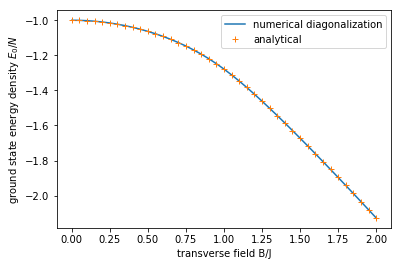

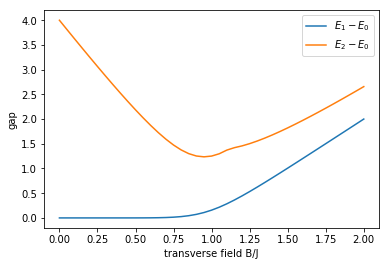

In [5]:
N = 10
dim = 2**N

sxis, syis, szis = BuildSingleSpinOps(N)
# print(sxis[0].toarray())
# print(syis[0].toarray())
# print(szis[0].toarray())
    
# calculate the ground state and compare to analytical result
Bvec = np.linspace(0,2,41)
result = np.zeros((len(Bvec),4))
for i in range(len(Bvec)):
    Hmat = Build_H_TFIM(N,Bvec[i])
    result[i,:3], evecs = sLA.eigsh(Hmat,k=3,which='SA') # numerical ground state energy
    result[i,3] = -np.sum(sqrt(1+Bvec[i]**2-2*Bvec[i]*cos(2*pi/N*np.arange(-(N-1)/2,(N-1)/2+1,1)))) # analytical ground state energy

plt.plot(Bvec,result[:,0]/N)
plt.plot(Bvec,result[:,3]/N,'+')
plt.legend(['numerical diagonalization','analytical'])
plt.xlabel('transverse field B/J')
plt.ylabel('ground state energy density $E_0/N$')
plt.show()

plt.plot(Bvec,result[:,1]-result[:,0])
plt.plot(Bvec,result[:,2]-result[:,0])
plt.legend(['$E_1-E_0$','$E_2-E_0$'])
plt.xlabel('transverse field B/J')
plt.ylabel('gap')
plt.show()

### Exercise 2: Taking partial traces (50 points)

The TFIM has a quantum phase transition at $B/J=1$ from a ferromagnetic to a paramagnetic phase. You can use your code from exercise 1 to see that the gap is mimimal around this value. Note that the model also has the $Z_2$ symmetry (invariance under flipping of all spins) which we saw in the collective Ising model, so you would look at the gap of ground and second excited state.
At the phase transition point, long-range correlations emerge in the ground state. An interesting feature is also that at the critical point the half-chain entanglement entropy diverges logarithmically as $N$ goes to infinity (see for example https://arxiv.org/abs/0803.3610 Fig. 3). For finite $N$ we should already see that the entanglement entropy becomes maximal approximately at the critical point.

To calculate the half-chain entanglement entropy in the ground state of the transverse Ising chain, you should proceed as follows:

1) Calculate the partial trace over $N/2$ spins. The matrix element of the reduced density of a state $|\psi\rangle = \sum_i c_i |i\rangle$ (where $|i\rangle$ are the $N$-spin basis states) can be expressed as
$$
(\rho_{red,N/2})_{ij} = \sum_{k=0}^{2^{N/2}-1} c_{i+k*2^{N/2}}c^*_{j+k*2^{N/2}}
$$
(This might look different depending on how the states are ordered in your basis.)

2) Calculate the eigenvalues $p_i$ of $\rho_{red,N/2}$, sort them from largest to smallest. This is the entanglement spectrum. The rank of $\rho_{red,N/2}$ is called entanglement dimension. For a separable state the entanglement dimension is 1, i.e. only one eigenvalue is non-zero.

3) Calculate the von-Neumann entanglement entropy $S_E = -\sum_i p_i \log(p_i)$. Consider that some of the eigenvalues can be zero. Due to the finite numerical precision they can even turn negative. These you want to exclude from the sum. (The limit $\lim_{p\rightarrow 0} p\log(p) =0$ so we are not actually modifying the outcome significantly by neglecting small p's.)

Test your code for some cases where you know the answer, for example a separable state or a Bell pair state of 2 qubits. The qutip module also has the capability of calculating partial traces. If you are interested you can compare to this for testing.

Then calcualte the entanglement spectrum and entropy for the same parameter scan as in exercise 1. Document your observations.

In [23]:
# note that my convention is that the basis states are ordered as {|00..0>,|1,0...0>,|010...0> etc}
# qutip uses the opposite convention. So if you trace over the lasst M spins in my code it should 
# give the same as tracing over the first M in qutip
def partialTrace(psi,M): # M = number of spins to be traced over (assumed to be spins N-M+1 to N)
    dim = len(psi)
    dimRed = 2**(N-M)
    rhoRed = 1j*np.zeros((dimRed,dimRed))
    for i in range(dimRed):
        for j in range(dimRed):
            rhoRed[i,j] = psi[range(i,dim,dimRed)].T @ psi[range(j,dim,dimRed)].conj()
    return rhoRed

# entanglement spectrum
def getEvals(rho):
    evals, evecs = LA.eigh(rho)
    return np.flip(evals)

# von Neumann entanglement entropy
def SvN(rho):
    ps = getEvals(rho)
    ps = ps[np.nonzero(np.around(ps,10))]
    return -np.sum(ps*np.log(ps))

In [25]:
# testing: I tested for Bell states and for 3 qubit states, comparing to qutip
N = 3
dim=2**N
Psi=(np.eye(1,dim,0)[0]+ np.eye(1,dim,dim-2)[0])/sqrt(2) # psi is a column vector
print(Psi)

rhoRed = partialTrace(Psi,1) # trace over the last spin
print(rhoRed)
    
ps = getEvals(rhoRed)
print(ps)

SvN(rhoRed)

# using qutip
psi = (tensor(basis(2, 0), basis(2, 0), basis(2, 0)) + tensor(basis(2, 1), basis(2, 1), basis(2, 0)) )/sqrt(2)
print(psi)
print(psi.ptrace([1,2])) # argument: vector of spins that should be kept (first spin has index 0)

[0.70710678 0.         0.         0.         0.         0.
 0.70710678 0.        ]
[[0.5+0.j 0. +0.j 0. +0.j 0. +0.j]
 [0. +0.j 0. +0.j 0. +0.j 0. +0.j]
 [0. +0.j 0. +0.j 0.5+0.j 0. +0.j]
 [0. +0.j 0. +0.j 0. +0.j 0. +0.j]]
[0.5 0.5 0.  0. ]
Quantum object: dims = [[2, 2, 2], [1, 1, 1]], shape = (8, 1), type = ket
Qobj data =
[[0.70710678]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.70710678]
 [0.        ]]
Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[0.5 0.  0.  0. ]
 [0.  0.  0.  0. ]
 [0.  0.  0.5 0. ]
 [0.  0.  0.  0. ]]


In [27]:
# apply to calculate ground state of Ising model
N=10
dim=2**N

sxis, syis, szis = BuildSingleSpinOps(N)

# calculate the ground state and its entanglement specturm and half chain entanglement entropy
Bvec = np.linspace(0,2,41)
SvNall = np.zeros((len(Bvec)))
EntSpecall = np.zeros((len(Bvec),int(2**(N/2))))
Sxall = np.zeros((len(Bvec)))
Szall = np.zeros((len(Bvec)))
for i in range(len(Bvec)):
    Hmat = Build_H_TFIM(N,Bvec[i])
    E0, evecs = sLA.eigsh(Hmat,k=1,which='SA') # numerical ground state
    rhoRed = partialTrace(evecs[:,0],int(N/2))
    EntSpecall[i] = getEvals(rhoRed)
    SvNall[i] = SvN(rhoRed)
    # spins expectation values: Due to translation invariance, we can look at any single spin (here the first)
    Sxall[i] = evecs[:,0].conj().T @ sxis[0] @ evecs[:,0]
    Szall[i] = evecs[:,0].conj().T @ szis[0] @ evecs[:,0]

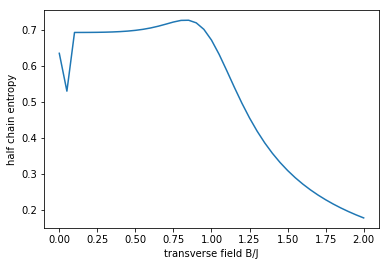

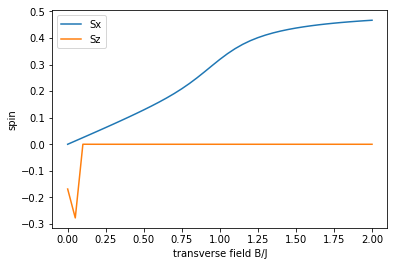

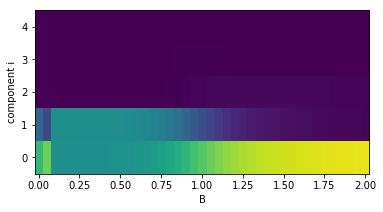

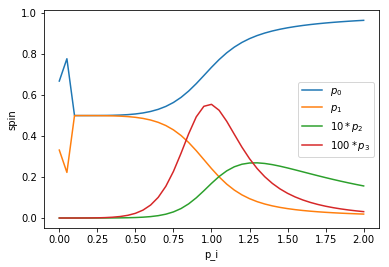

In [29]:
plt.plot(Bvec,SvNall)
# plt.legend(['numerical diagonalization','analytical'])
plt.xlabel('transverse field B/J')
plt.ylabel('half chain entropy')
plt.show()

plt.plot(Bvec,Sxall)
plt.plot(Bvec,Szall)
plt.legend(['Sx','Sz'])
plt.xlabel('transverse field B/J')
plt.ylabel('spin')
plt.show()

dB=Bvec[1]-Bvec[0]
iTo = 5
plt.imshow(np.flip(EntSpecall[:,:5],axis=1).T, extent=[Bvec[0]-dB/2, Bvec[-1]+dB/2, 0-0.5, 5-0.5],vmax=1,aspect=.2)
plt.xlabel('B')
plt.ylabel('component i')
plt.show()

plt.plot(Bvec,EntSpecall[:,0])
plt.plot(Bvec,EntSpecall[:,1])
plt.plot(Bvec,10*EntSpecall[:,2])
plt.plot(Bvec,100*EntSpecall[:,3])
# plt.plot(Bvec,1000*EntSpecall[:,4])
plt.xlabel('p_i')
plt.ylabel('spin')
plt.legend(['$p_0$','$p_1$','$10*p_2$','$100*p_3$'])
plt.show()

One can see the numerical instability due to the degeneracy od the ground state as we hjad it in the collective case.

As expected the entanglement entropy is peaked at the critical point and one sees that higher Schmidt numbers build up there.

The limits are as expected:  At large field, the ground state is a product state $|++...+\rangle$ and thus zero entanglement entropy, and at low field it is a cat state $(|00...0\rangle+|11...1\rangle)/\sqrt(2)$, which has $p_0=p_1=1/2$ and thus $S_E=\log(2)$.

### Optional Exercise 3: Time-dependence of entanglement entropy

Calculate the time-evolution for all spins being in the state $|+\rangle = (|0\rangle+|1\rangle)/\sqrt{2}$ initially.

If you evolve this state with the critical Ising Hamiltonian, the enatnglement entropy should increase very rapidly in time and saturate due to the finite system size. The saturation value is extensive in system size (volume law). This makes simulating the time evolution for quenches near the critical point challenging for techniques based on matrix prduct states (next lecture). 

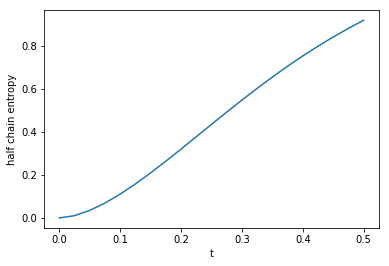

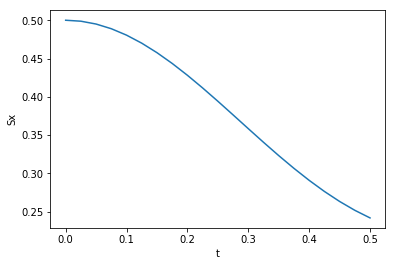

In [15]:
N = 10
dim = 2**N
tvec = np.linspace(0,.5,21)
ini = np.full(dim,1/sqrt(dim)) # all along x

sxis, syis, szis = BuildSingleSpinOps(N)

Hmat = Build_H_TFIM(N,1)
evals, evecs = LA.eigh(Hmat.toarray()) # full diagonalization
iniProj = evecs.conj().T @ ini

SxTable2 = 1j*np.zeros((len(tvec)))
SvNall = np.zeros((len(tvec)))
EntSpecall = np.zeros((len(Bvec),int(2**(N/2))))
for it in range(len(tvec)):
    Psit = evecs @ (np.exp(-1j*evals*tvec[it])*iniProj)
    SxTable2[it] = Psit.conj().T @ sxis[0] @ Psit
    rhoRed = partialTrace(Psit,int(N/2))
    EntSpecall[it] = getEvals(rhoRed)
    SvNall[it] = SvN(rhoRed)

plt.plot(tvec,SvNall)
# plt.legend(['numerical diagonalization','analytical'])
plt.xlabel('t')
plt.ylabel('half chain entropy')
plt.show()

plt.plot(tvec,SxTable2.real)
# plt.legend(['numerical diagonalization','analytical'])
plt.xlabel('t')
plt.ylabel('Sx')
plt.show()

### Optional Exercise 4: Spin squeezing and entanglement

Let us look at the collective Ising spin-model with a transverse field one last time. The Hamiltonian is still
$$
H=-\frac{J}{N}S_z^2 - \Omega S_x
$$
with the collective spin operators $S_\alpha = \sum_i \sigma_i^\alpha/2$, where $\sigma_i^\alpha$ is a Pauli operator acting on spin $i$. This time we want to examine how spin squeezed states form under the dynamics of this model. All we have to do is to initialize the system with all spins pointing along the x-direction, i.e. in the coehrent spin state $|CSS(\pi/2,0)\rangle$. For any small value of $\Omega$ (we can actually choose $\Omega=0$) we will observe spin squeezing.
Plot the Husimi distribution of the state using the "front view" form programming exercise 6 and observe how it evolves with time. Evaluate $S_x$ and the variance in any direction perpendicular to $S_x$ by rotating the state about the x-axis and calculating the variance of $S_z$ to determine the direction of maximal squeezing.

Calculate the optimal squeezing parameter $\min_{\mathbf{n}_\perp} = N (\Delta (\mathbf{n}_\perp\cdot \mathbf{S}))^2/\langle S_x\rangle^2$ as a function of time. Whay does it increase again after some time?

Spin squeezing is associated with the buildup of entanglement. Calculate the entanglement entropy for the above time evolution. You can use the techniques from exercises 1 and 2 for this and solve the collective Ising model in the product basis, which of course allows you only to go to small numbers of spins, but the effects will still be visible. Note that one can also calculate the reduced density using symmetrized Dicke states (see https://arxiv.org/abs/cond-mat/0409611). You can implement this as a cross check and for going to larger N.

The *solution* of this exercise will be part of one of the programming projects and is therefore not provided here.